# Deconvolution performance on the mouse brain dataset (Fig 3d-g)

In [1]:
import warnings
import os
import itertools
import torch
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
from plotnine import *

## Visualizations of spatial data and the scRNA-seq reference (Fig 3d)

### Load spatial data

In [2]:
from matplotlib.image import imread
import json

def read_sp_data(data_dir, sample_id):
    count_dir = f"{data_dir}/ST/{sample_id}/{sample_id}_filtered_feature_bc_matrix.h5"
    sp_dir = f"{data_dir}/ST/{sample_id}/spatial/"
    
    # load counts
    adata = sc.read_10x_h5(count_dir)
    adata.var_names_make_unique()
    
    # load spatial data
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][sample_id] = dict()

    files = dict(
        tissue_positions_file = sp_dir + '/tissue_positions_list.csv',
        scalefactors_json_file = sp_dir + '/scalefactors_json.json',
        hires_image = sp_dir + '/tissue_hires_image.png',
        lowres_image = sp_dir  + '/tissue_lowres_image.png',
    )

    adata.uns["spatial"][sample_id]['images'] = dict()

    for res in ['hires', 'lowres']:
        try:
            adata.uns["spatial"][sample_id]['images'][res] = imread(
                str(files[f'{res}_image'])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    with open(files['scalefactors_json_file']) as f:
        js = json.load(f)
    adata.uns["spatial"][sample_id]['scalefactors'] = js

    # read coordinates
    positions = pd.read_csv(files['tissue_positions_file'], header=None)
    positions.columns = [
        'barcode',
        'in_tissue',
        'array_row',
        'array_col',
        'pxl_col_in_fullres',
        'pxl_row_in_fullres',
    ]
    positions.index = positions['barcode']

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
    adata.obs.drop(
        columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
        inplace=True,
    )
    
    return adata

In [3]:
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/mouse_brain_visium/"
sample_id = "ST8059048"
sp_data = read_sp_data(data_dir, sample_id)
sc.pp.filter_genes(sp_data, min_cells=10)

/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


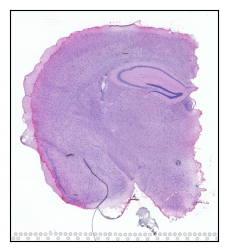

In [4]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    axes = sc.pl.spatial(sp_data, size=2, show = False)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    plt.show()

In [5]:
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.spatial(sp_data, size = 2, show = False,
                  save = "fig2d_left.pdf")

### Load single-cell reference

In [6]:
import warnings
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/mouse_brain_visium/"
sample_id_list = ['5705STDY8058280', '5705STDY8058281', '5705STDY8058282']

adata_list = []
for s_id in sample_id_list:
    _ad = sc.read_10x_h5(f"{data_dir}/scref/{s_id}_filtered_feature_bc_matrix.h5")
    _ad.var_names_make_unique()
    _ad.obs['sample_id'] = s_id
    _ad.obs['cell_id'] = _ad.obs['sample_id'] + '_' +  _ad.obs_names
    adata_list.append(_ad)


scref = ad.concat(adata_list)
scref.obs = scref.obs.set_index('cell_id')

del adata_list

/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make

#### Add cell type annotation

In [8]:
# load cell type annotation
ct_anno = pd.read_csv(
    data_dir + "/scref/cell_annotation.csv",
    sep = ',', header = 0
)
ct_anno.columns = ['cell_id', 'sample_id', 'cell_type', 'cel_type_print']
ct_anno.set_index('cell_id', inplace = True)

# add to meta
scref.obs = pd.merge(scref.obs, ct_anno, how = 'left', on = ['cell_id', 'sample_id'])
scref = scref[~scref.obs['cell_type'].isna()]

# remove unknown and low-qual cell types
ct_to_remove = ['Unk_1', 'Unk_2', 'Ext_Unk_1', 'Ext_Unk_2', 'Ext_Unk_3', 'LowQ_1', 'LowQ_2']
scref = scref[~scref.obs['cell_type'].isin(ct_to_remove)]

In [9]:
scref.obs['cell_type'].unique(), len(scref.obs['cell_type'].unique())

(array(['Ext_L25', 'Ext_L56', 'Ext_Thal_1', 'Ext_L5_1', 'Ext_Thal_2',
        'Ext_L23', 'Oligo_2', 'Inh_1', 'Ext_Hpc_DG2', 'OPC_1', 'Inh_Sst',
        'Ext_L6', 'Inh_Meis2_2', 'Inh_3', 'Ext_Pir', 'Ext_L5_3', 'Inh_4',
        'Ext_Hpc_DG1', 'Inh_Lamp5', 'Astro_STR', 'Astro_CTX', 'Nb_1',
        'Inh_Meis2_4', 'Inh_Meis2_3', 'Inh_Pvalb', 'Micro', 'OPC_2',
        'Astro_AMY', 'Oligo_1', 'Inh_6', 'Ext_Amy_2', 'Astro_THAL_lat',
        'Inh_Meis2_1', 'Astro_AMY_CTX', 'Ext_L6B', 'Ext_L5_2',
        'Ext_Hpc_CA1', 'Inh_Vip', 'Astro_THAL_med', 'Astro_HYPO', 'Inh_2',
        'Ext_Hpc_CA3', 'Ext_ClauPyr', 'Nb_2', 'Ext_Med', 'Astro_HPC',
        'Ext_Hpc_CA2', 'Astro_WM', 'Inh_5', 'Astro_THAL_hab', 'Ext_Amy_1',
        'Endo'], dtype=object),
 52)

#### QC

In [10]:
sc.pp.filter_cells(scref, min_genes=200)
sc.pp.filter_genes(scref, min_cells=10)

/Users/jysumac/miniforge3/envs/sp_dev/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [11]:
scref.var['mt'] = scref.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scref, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#### Visualization

In [12]:
sc.pp.normalize_total(scref, target_sum=1e4)
sc.pp.log1p(scref)
sc.pp.highly_variable_genes(scref)
scref.raw = scref
sc.pp.scale(scref, max_value=10)

In [13]:
sc.tl.pca(scref, svd_solver='arpack')
sc.pp.neighbors(scref, n_neighbors=10, n_pcs=40)
sc.tl.umap(scref)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


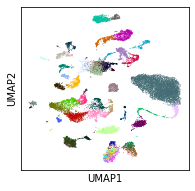

In [14]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(scref, color='cell_type', legend_loc = None, title = '', size = 2)

In [15]:
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.umap(
        scref, color='cell_type', legend_loc = None, title = '', size = 2,
        show = False, save = "fig2d_right.pdf"
    )

In [16]:
del scref

## Visualizations of deconvolution results (Fig 3e-g)

### Load deconvolution results

In [3]:
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/mouse_brain_visium/"
res_dir = "/Users/jysumac/Projects/Smoother_paper/results/mouse_brain_visium/"

sample_id = "ST8059048"
sp_data = read_sp_data(data_dir, sample_id)
sc.pp.filter_genes(sp_data, min_cells=10)

ct_names = pd.read_csv(f"{data_dir}/scref/ref_avg_logcount_nm20.csv", 
                       header=0, index_col=0, nrows=0).columns
coords = sp_data.obsm['spatial']

l_sp_list = [0, 0.3, 1]
method_names = [f"nnls_sp{str(l_sp)}" for l_sp in l_sp_list] + \
                [f"dwls_sp{str(l_sp)}" for l_sp in l_sp_list]

p_inf_list = [np.loadtxt(f"{res_dir}/nm50/{sample_id}/{name}.txt") 
              for name in method_names]

# load card results run on all genes
card_names = ["card_sp0", "card_sp1"]
p_card_list = [np.loadtxt(f"{res_dir}/nmc/{sample_id}/{name}.txt") 
              for name in card_names]

method_all_names = method_names + card_names
p_all_list = p_inf_list + p_card_list

/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Excitatory neurons in cortex

In [4]:
def prop2alpha(props):
    if isinstance(props, pd.DataFrame):
        p = props.to_numpy()
    else:
        p = props

    # scale maximum props to 1
    return p / (p.max(axis = 0, keepdims = True) + 1e-8)

def res2df_ctx(p_inf, ct_names = ct_names, coords = coords): 
    # extract cortical excitatory neurons
    ct_to_plot = ['Ext_L23', 'Ext_L25', 'Ext_L56']
    ct_idx = [np.where(ct_names == ct)[0][0] for ct in ct_to_plot]
    props_l2356 = p_inf[:, ct_idx]
    l5_ind = np.where(ct_names.str.contains('Ext_L5_'))[0]
    props_l5 = p_inf[:,l5_ind].sum(1, keepdims = True)
    l6_ind = np.where(ct_names.str.contains('Ext_L6'))[0]
    props_l6 = p_inf[:,l6_ind].sum(1, keepdims = True)
    
    props_list = [props_l2356, props_l5, props_l6]
    
    # merge all results
    df = pd.DataFrame(
        np.concatenate([coords, *props_list], axis=1),
        columns = ['x', 'y', 'Ext_L23', 'Ext_L25', 'Ext_L56', 'Ext_L5', 'Ext_L6']
    )
    
    return df

def merge_all_method_dfs(df_list, ct_to_plot):
    df = pd.concat(df_list)
    
    # scale per cell type
    props = df[ct_to_plot]
    df[ct_to_plot] = prop2alpha(props)
    
    # convert props to alpha
    df = pd.melt(df, id_vars=['x', 'y', 'method'],
                 value_vars=ct_to_plot,
                 var_name='celltype', value_name='alpha'
                )
    return df

In [5]:
ct_colors = {
    'Ext_L23': '#e41a1c', 
    'Ext_L25': '#ffff33',
    'Ext_L5': '#4daf4a',
    'Ext_L56': '#377eb8', 
    'Ext_L6': '#984ea3'
}

ct_to_plot = ['Ext_L23', 'Ext_L25', 'Ext_L56', 'Ext_L5', 'Ext_L6']
method_to_plot = ['dwls_sp0', 'dwls_sp1', 'card_sp0', 'card_sp1']
method_to_plot_names = ['DWLS (-)', 'DWLS (+ spatial loss)', 'CARD (-)', 'CARD (+ spatial loss)']
method_idx = [np.where(np.array(method_all_names) == name)[0][0] for name in method_to_plot]
n_method = len(method_to_plot)

df_all = []
for m_id, name in enumerate(method_to_plot_names): 
    p_inf = p_all_list[method_idx[m_id]]
    df = res2df_ctx(p_inf)
    df['method'] = name
    df_all.append(df)

df_all = merge_all_method_dfs(df_all, ct_to_plot)
df_all['method'] = pd.Categorical(df_all['method'], categories=method_to_plot_names)

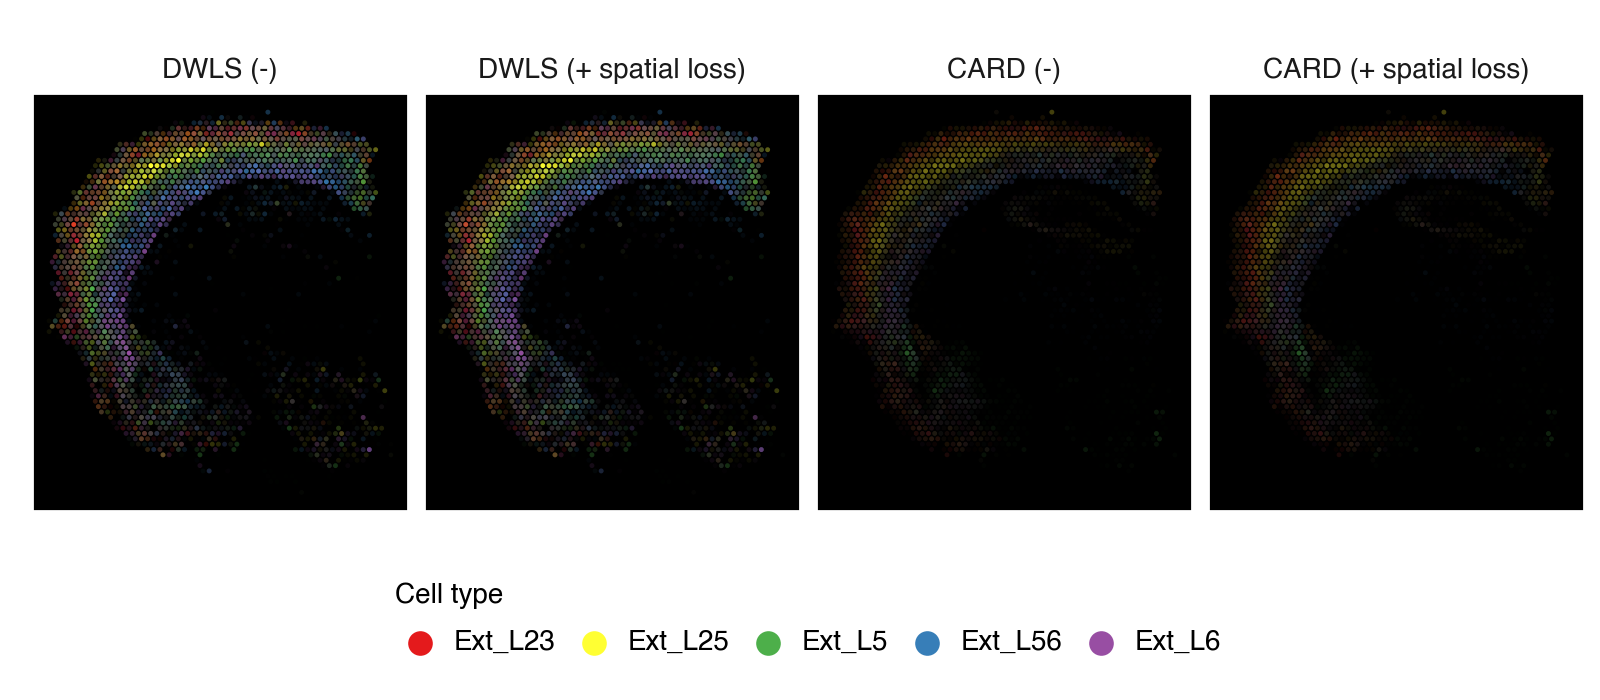

<Figure Size: (800 x 350)>

In [10]:
fontsize = 10
p1 = (
    ggplot(df_all) + 
        facet_wrap('~method', nrow = 1) + 
        geom_point(aes(x = 'x', y = '-y',
                       fill = 'celltype', alpha = 'alpha'),
                   size = 1, stroke = 0, color = 'black') + 
        scale_alpha_continuous(range = [0, 1]) + 
        scale_fill_manual(values = ct_colors) +
        labs(fill = 'Cell type', x = '', y = '') +
        theme_void() + 
        theme(figure_size = (2*n_method, 3.5), 
              text = element_text(size = fontsize),
              axis_text_x = element_blank(),
              axis_text_y = element_blank(),
              panel_background = element_rect(fill = 'black'),
              panel_border = element_rect(color = 'white', size = 1),
              legend_position = 'bottom'
        ) + 
        guides(alpha = False,
               fill = guide_legend(override_aes = {'size':5}))
)
p1

### Excitatory neurons in HPC

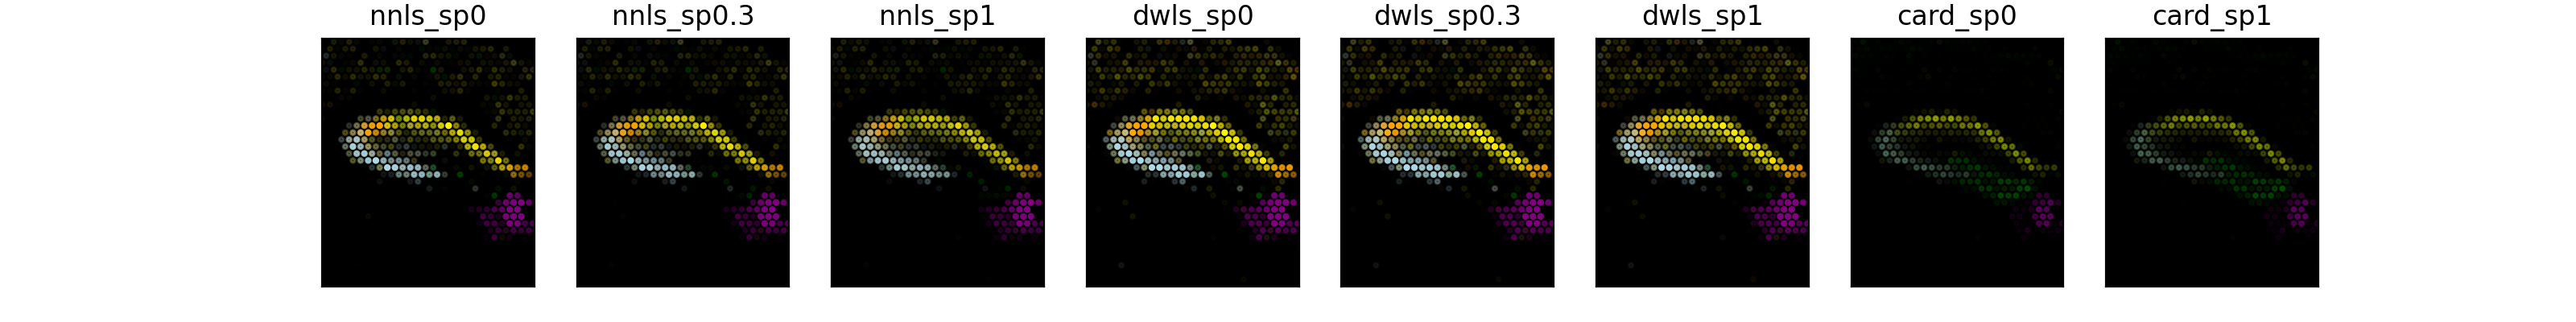

In [11]:
# Excitatory neurons in HPC
ct_to_plot = [f"Ext_Hpc_{n}" for n in ['CA1', 'CA2', 'CA3', 'DG1']] + ["Inh_6"]
colors = ['yellow', 'orange', 'lightblue', 'green', 'purple']
ct_idx = [np.where(ct_names == ct)[0][0] for ct in ct_to_plot]

n_method = len(method_all_names)
n_ct = len(ct_to_plot)
fig, axes = plt.subplots(1, n_method, figsize = (2*n_method, 2))

for m_id, (p_inf, name) in enumerate(zip(p_all_list, method_all_names)): 
    axes[m_id].set_title(name)
    
    alpha = p_inf[:, ct_idx]
    alpha = (alpha * 2).clip(0, 1)
    
    for i in range(n_ct):
        axes[m_id].scatter(coords[:,0], - coords[:,1], c = colors[i],
                         alpha = alpha[:, i], s = 4)

x_min = 0.45*(coords[:,0].max() - coords[:,0].min()) + coords[:,0].min()
x_max = 0.95*(coords[:,0].max() - coords[:,0].min()) + coords[:,0].min()
y_min = 0.45*((-coords[:,1]).max() - (-coords)[:,1].min()) + (-coords)[:,1].min()
y_max = 0.95*((-coords[:,1]).max() - (-coords)[:,1].min()) + (-coords)[:,1].min()

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_facecolor('black')

plt.show()

In [12]:
# Excitatory neurons in HPC
def res2df_hpc(p_inf, ct_names = ct_names, coords = coords): 
    # extract cortical excitatory neurons
    ct_to_plot = [f"Ext_Hpc_{n}" for n in ['CA1', 'CA2', 'CA3', 'DG1']] + ["Inh_6"]
    ct_idx = [np.where(ct_names == ct)[0][0] for ct in ct_to_plot]
    props = p_inf[:, ct_idx]
    
    # merge all results
    df = pd.DataFrame(
        np.concatenate([coords, props], axis=1),
        columns = ['x', 'y', *ct_to_plot]
    )
    return df

In [13]:
ct_colors = {
    'Ext_Hpc_CA1': '#e41a1c', 
    'Ext_Hpc_CA2': '#ffff33',
    'Ext_Hpc_CA3': '#4daf4a',
    'Ext_Hpc_DG1': '#377eb8', 
    'Inh_6': '#984ea3'
}

ct_to_plot = [f"Ext_Hpc_{n}" for n in ['CA1', 'CA2', 'CA3', 'DG1']] + ["Inh_6"]
method_to_plot = ['dwls_sp0', 'dwls_sp1', 'card_sp0', 'card_sp1']
method_to_plot_names = ['DWLS (-)', 'DWLS (+ spatial loss)', 'CARD (-)', 'CARD (+ spatial loss)']
method_idx = [np.where(np.array(method_all_names) == name)[0][0] for name in method_to_plot]
n_method = len(method_to_plot)

df_all = []
for m_id, name in enumerate(method_to_plot_names): 
    p_inf = p_all_list[method_idx[m_id]]
    df = res2df_hpc(p_inf)
    df['method'] = name
    df_all.append(df)

df_all = merge_all_method_dfs(df_all, ct_to_plot)
df_all['method'] = pd.Categorical(df_all['method'], categories=method_to_plot_names)

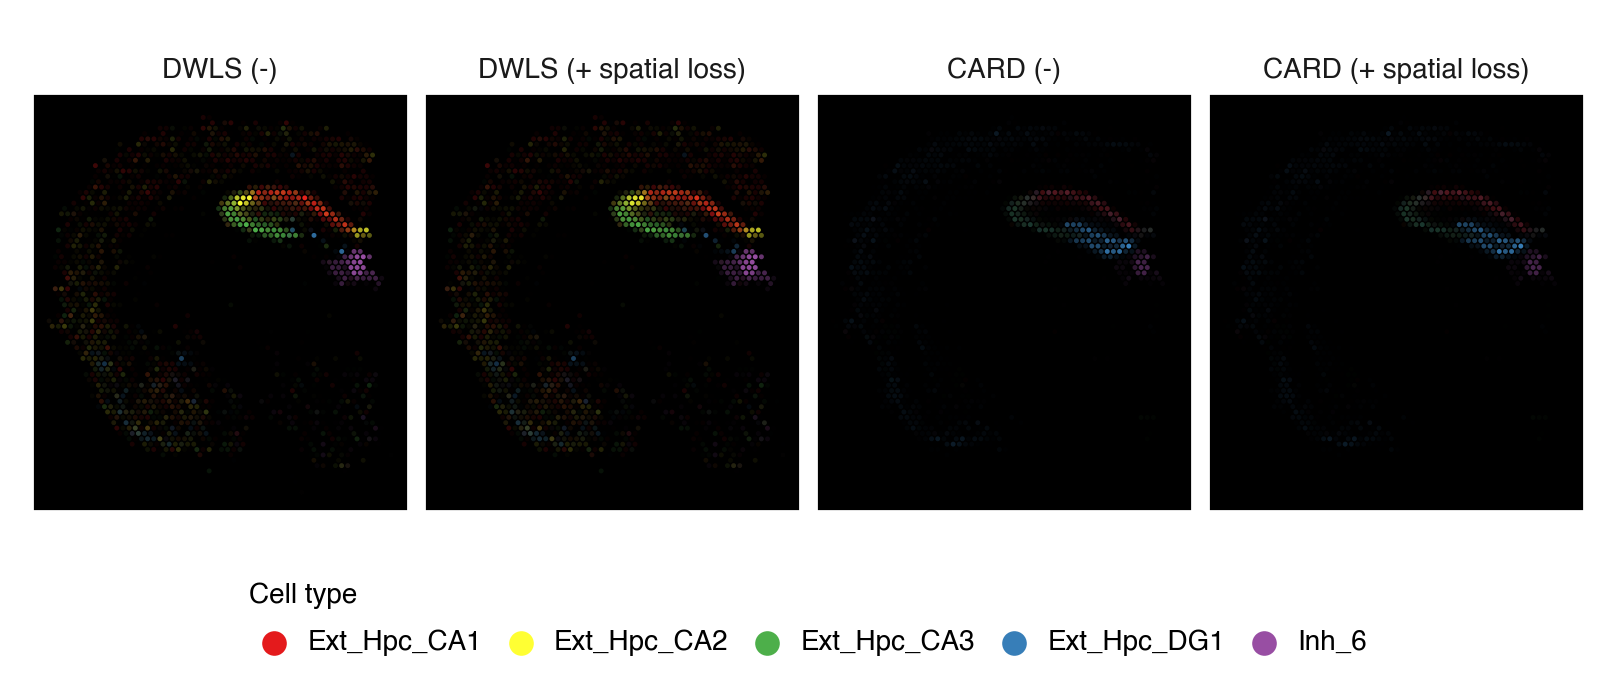

<Figure Size: (800 x 350)>

In [14]:
fontsize = 10
p2 = (
    ggplot(df_all) + 
        facet_wrap('~method', nrow = 1) + 
        geom_point(aes(x = 'x', y = '-y',
                       fill = 'celltype', alpha = 'alpha'),
                   size = 1, stroke = 0, color = 'black') + 
        scale_alpha_continuous(range = [0, 1]) + 
        scale_fill_manual(values = ct_colors) + 
        labs(fill = 'Cell type', x = '', y = '') +
        theme_void() + 
        theme(figure_size = (2*n_method, 3.5), 
              text = element_text(size = fontsize),
              axis_text_x = element_blank(),
              axis_text_y = element_blank(),
              panel_background = element_rect(fill = 'black'),
              panel_border = element_rect(color = 'white', size = 1),
              legend_position = 'bottom'
        ) + 
        guides(alpha = False,
               fill = guide_legend(override_aes = {'size':5}))
)

p2

### Clustering of cell-type compositions

In [15]:
from smoother.visualization import cluster_features

clu_inf_list = [cluster_features(p_inf, transform = 'pca', n_neighbors=38, res = 0.9)
                for p_inf in p_inf_list]
clu_card_list = [cluster_features(p_inf, transform = 'pca', n_neighbors=38, res = 1.1)
                 for p_inf in p_card_list]
clu_all_list = clu_inf_list + clu_card_list

/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/jysumac/miniforge3/envs/smoother_paper/lib/python3.10/site

In [16]:
[len(clu.unique()) for clu in clu_all_list]

[15, 16, 17, 17, 16, 17, 16, 16]

In [17]:
def get_cost_matrix(clu1, clu2):
    n_clu1 = len(clu1.unique())
    n_clu2 = len(clu2.unique())
    cm = np.zeros((n_clu1, n_clu2))
    
    for i in range(n_clu1):
        clu_ind = (clu1 == str(i))
        for j in range(n_clu2):
            cm[i, j] = -(clu2[clu_ind] == str(j)).sum()
    return cm
        

def align_clusters(clu_list, ref_ind = None):
    n_clu_list = [len(clu.unique()) for clu in clu_list]
    if ref_ind == None:
        ref_ind = np.argmax(n_clu_list)
    
    clu_aligned_list = []
    for i, clu in enumerate(clu_list):
        if i == ref_ind:
            clu_aligned_list.append(clu)
        else:
            #n_clu = len(clu.unique())
            n_clu = len(clu_list[ref_ind].unique())
            cm = get_cost_matrix(clu, clu_list[ref_ind])
            row_ind, col_ind = sp.optimize.linear_sum_assignment(cm)
            clu_aligned_list.append(
                clu.cat.rename_categories(col_ind).astype(str)
            )
    
    return clu_aligned_list, ref_ind

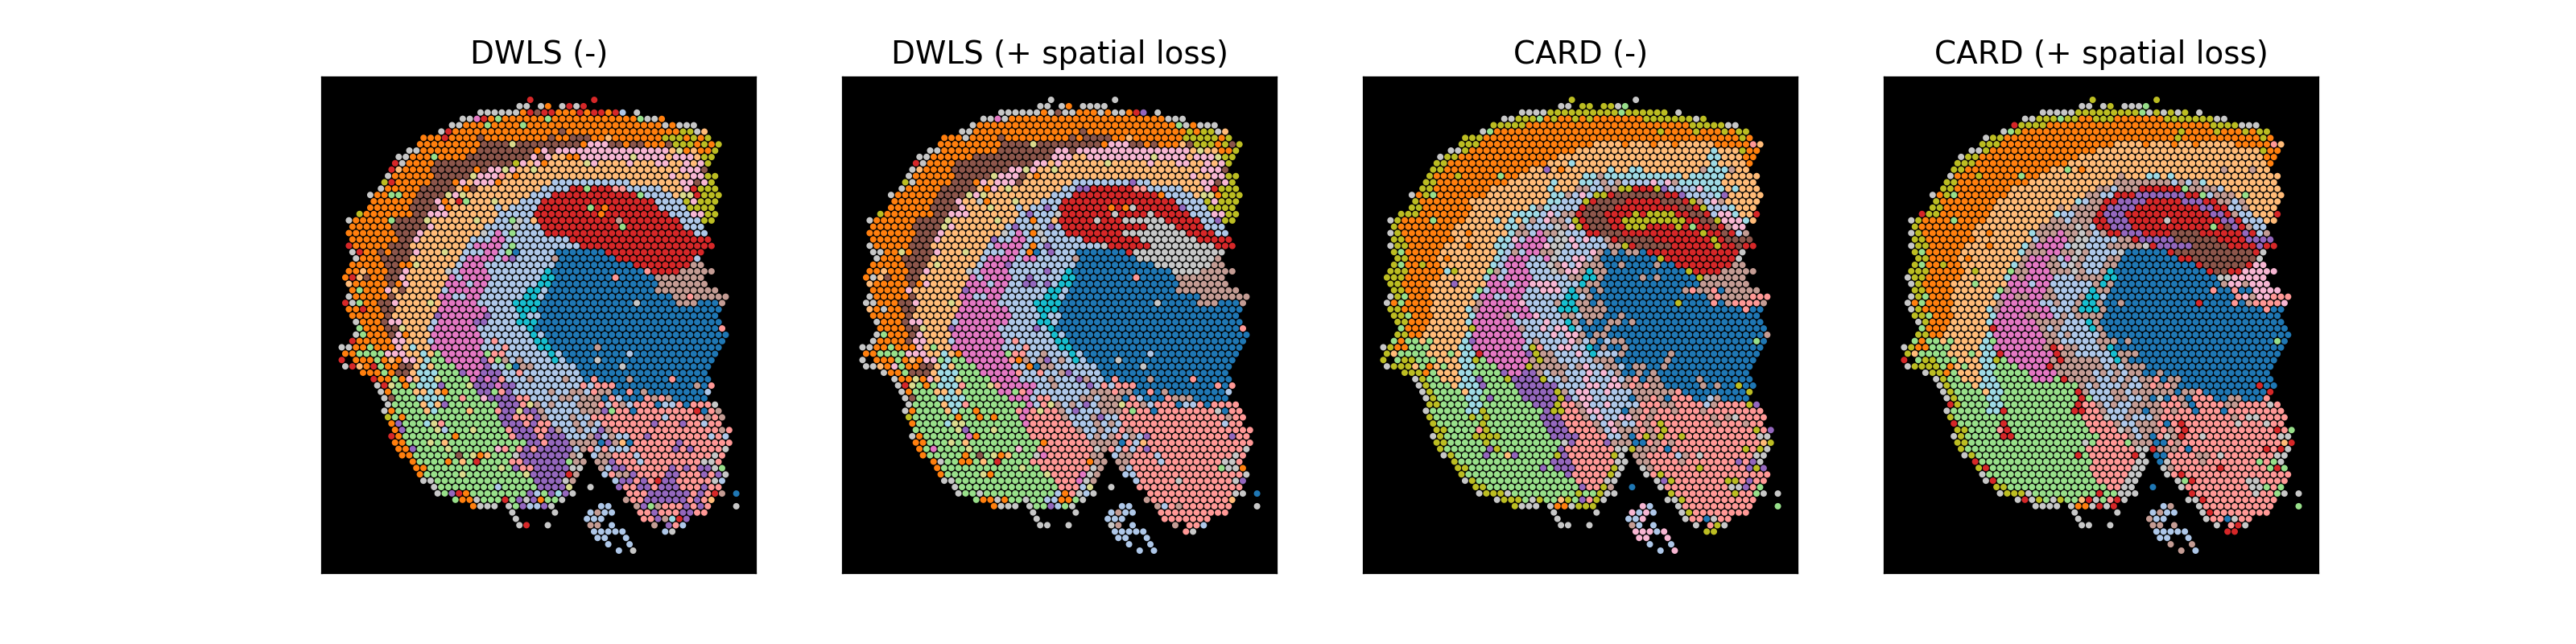

In [18]:
method_to_plot = [#'nnls_sp0', 'nnls_sp1', 
                  'dwls_sp0', 'dwls_sp1', 'card_sp0', 'card_sp1']
method_to_plot_names = [#'NNLS (-)', 'NNLS (+ spatial loss)', 
                        'DWLS (-)', 'DWLS (+ spatial loss)', 
                        'CARD (-)', 'CARD (+ spatial loss)']
method_idx = [np.where(np.array(method_all_names) == name)[0][0] for name in method_to_plot]
n_method = len(method_to_plot)

clu_aligned_list, ref_ind = align_clusters([clu_all_list[i] for i in method_idx])

fontsize = 14

fig, axes = plt.subplots(1, n_method, figsize = (4*n_method, 4))

for row_id, (p_inf, name) in enumerate(zip(p_all_list, method_to_plot_names)): 
    axes[row_id].set_title(name, fontsize=fontsize)

    axes[row_id].scatter(coords[:,0], - coords[:,1], 
                         c = clu_aligned_list[row_id].to_numpy().astype(float), 
                         cmap='tab20', s = 3.5)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')

plt.show()

In [19]:
ref_ind

0